В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

Area under ROC score on Training dataset: 0.7683


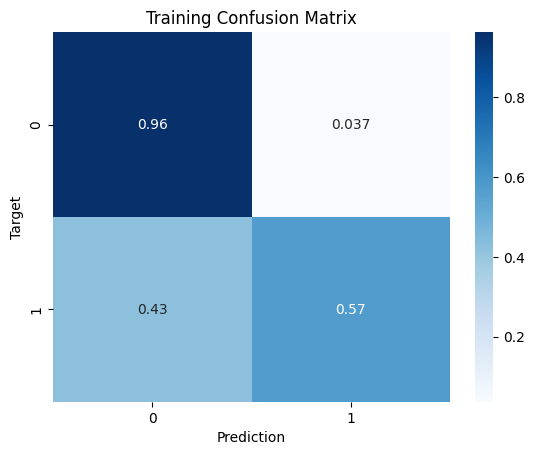

Area under ROC score on Validation dataset: 0.7560


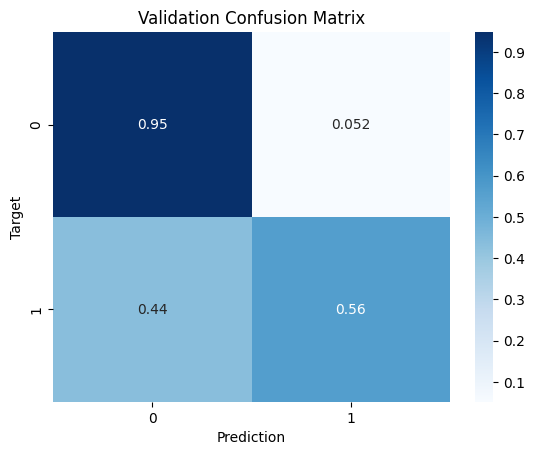

In [3]:
# Creating training and validation sets
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Identifying numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Creating transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combining transformers for different column types into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Creating a pipeline that first preprocesses and then trains a model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Training the pipeline
model_pipeline.fit(train_inputs, train_targets)

# Function to make predictions and calculate metrics
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Evaluating the model on training and validation data
train_preds = predict_and_plot(train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Saving the model for future use
joblib.dump(model_pipeline, 'aussie_rain_pipeline.joblib')

# Loading the trained model
model_pipeline_loaded = joblib.load('aussie_rain_pipeline.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [5]:
import operator
from sklearn.preprocessing import PolynomialFeatures

In [6]:
numeric_transformer_poly = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2))
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_poly.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Surname', 'Geography',
                                                   'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Test dataset: 0.7999%


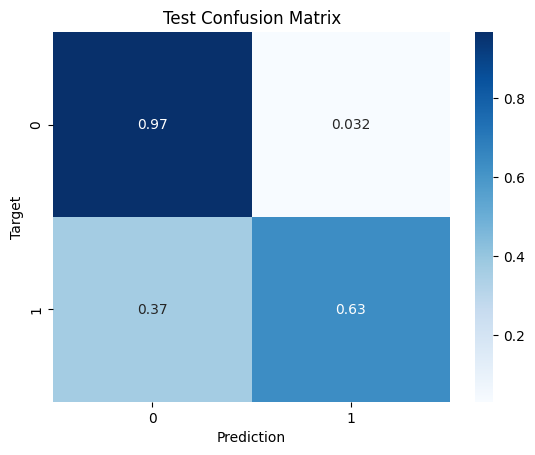

Area under ROC score on Validation dataset: 0.7893%


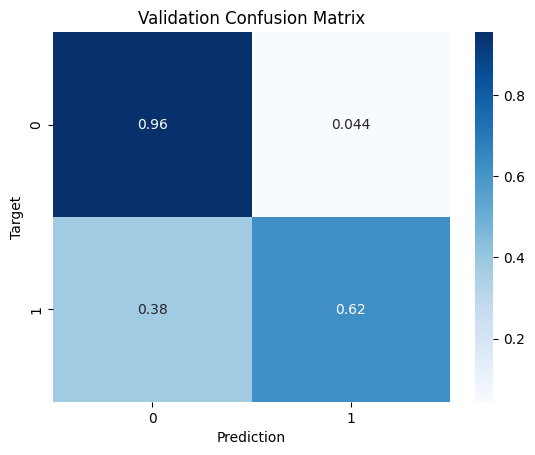

In [7]:
def predict_and_plot_poly(inputs, targets, name=''):
    preds = model_pipeline_poly.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Evaluating the model on training and validation data
train_preds = predict_and_plot_poly(train_inputs, train_targets, 'Test')
val_preds = predict_and_plot_poly(val_inputs, val_targets, 'Validation')

## Conclusion:
Conclusion:
	•	Overfitting/Underfitting: The model does not exhibit clear signs of overfitting or underfitting. It performs similarly on training and validation datasets.
	•	Generalization: The model generalizes adequately but might not fully capture the complexities of the data, as shown by the moderate ROC scores.

Overfitting/Underfitting: 
- The model does not exhibit clear signs of overfitting or underfitting. It performs similarly on training and validation datasets.
Generalization:
- The model generalizes adequately but might not fully capture the complexities of the data, as shown by the moderate ROC scores.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [25]:
numeric_transformer_poly_4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4))
])


preprocessor_poly_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly_4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_poly_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly_4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline_poly_4.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=4))]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Surname', 'Geography',
                                                   'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Test dataset: 0.8300%


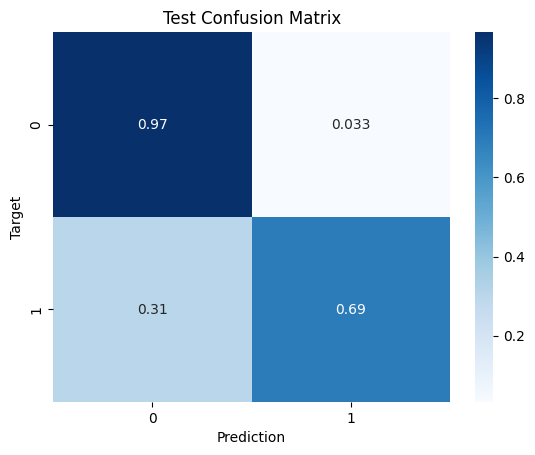

Area under ROC score on Validation dataset: 0.8094%


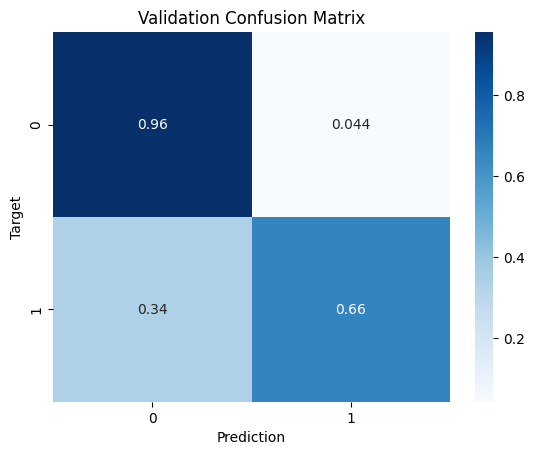

In [26]:
def predict_and_plot_poly_4(inputs, targets, name=''):
    preds = model_pipeline_poly_4.predict(inputs)
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot_poly_4(train_inputs, train_targets, 'Test')
val_preds = predict_and_plot_poly_4(val_inputs, val_targets, 'Validation')

## Conclusion
ROC improved a lot, I like this model!

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [8]:
raw_df = pd.read_csv('regression_data.csv')

In [9]:
raw_df

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013
...,...,...,...,...,...,...
124,1.402794,0.586857,-1.401851,0.791032,-0.909387,39.626185
125,-0.288659,-0.827231,0.322719,-1.002529,-0.018513,-50.585687
126,-1.407464,-0.213447,-0.718444,0.232050,-1.448084,13.719861
127,1.353872,1.237816,-0.114540,-0.469176,-1.713135,-23.851350


In [15]:
raw_df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,-0.082039,-0.017872,0.092293,-0.076084,0.053098,-3.902984
std,0.941214,1.065887,0.978557,0.910588,1.004498,45.466621
min,-3.241267,-2.619745,-1.913280,-2.211135,-2.301921,-111.753810
25%,-0.699726,-0.756351,-0.553649,-0.730367,-0.772825,-37.339533
50%,-0.066080,-0.161286,0.120296,0.018418,0.013002,-0.641298
75%,0.529804,0.679598,0.624120,0.519347,0.787085,25.464414
max,2.122156,3.852731,3.078881,2.314659,2.075401,115.125907


In [10]:
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42)

In [11]:
import operator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [12]:
#
polynomial_features = PolynomialFeatures(degree=3)
#
input_cols = list(train_df.columns)[1:-1]
target_col = 'target'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]
#
poly_features = PolynomialFeatures(degree=5)
train_inputs = poly_features.fit_transform(train_inputs)
val_inputs = poly_features.transform(val_inputs)
#
model = LinearRegression().fit(train_inputs, train_targets)

In [13]:
# Making predictions with the model
y_train_pred = model.predict(train_inputs)
y_val_pred = model.predict(val_inputs)

# Calculating the loss
train_loss = mean_squared_error(train_targets, y_train_pred)
val_loss = mean_squared_error(val_targets, y_val_pred)

print(f'Model error on the training dataset: {round(train_loss, 2)}')
print(f'Model error on the testing dataset: {round(val_loss, 2)}')

Model error on the training dataset: 0.0
Model error on the testing dataset: 1929.8


## Conclusion
The model does not generalize well. A training error of 0.0 indicates overfitting, where the model perfectly memorizes the training data but fails to perform well on unseen data, as shown by the high testing error (1929.8). The model likely needs regularization, better preprocessing, or simpler architecture to improve generalization.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [48]:
raw_df = pd.read_csv('regression_data.csv')
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42)

input_cols = list(train_df.columns)[1:-1]
target_col = 'target'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

In [45]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = mean_squared_error(y_train, y_train_pred)
    val_metrics = mean_squared_error(y_val, y_val_pred)

    return dict(train=train_metrics, val=val_metrics)

In [69]:
import warnings
warnings.filterwarnings("ignore")

for el in range(1, 21):
    print('Degree', el)
    poly_features = PolynomialFeatures(degree=el)
    X_train_poly = poly_features.fit_transform(train_inputs)
    X_val_poly = poly_features.transform(val_inputs)

    for model in models:
        model.fit(X_train_poly, train_targets)
        eval_results  = evaluate_model(model, X_train_poly, train_targets, X_val_poly, val_targets)
        print(f'{str(model)}: {eval_results:}\n')

Degree 1
LinearRegression(): {'train': 1.1588653163003415, 'val': 0.7230919061086551}

Ridge(): {'train': 1.4552604227961023, 'val': 0.9840720900509871}

Ridge(alpha=2): {'train': 2.315306404908446, 'val': 1.946705780068523}

Lasso(): {'train': 2.4687432520744452, 'val': 2.288021460973845}

ElasticNet(): {'train': 309.01561037762536, 'val': 386.8821871480164}

ElasticNet(alpha=0.5): {'train': 120.2038829913588, 'val': 148.51755451405108}

Degree 2
LinearRegression(): {'train': 1.0816968737887107, 'val': 0.835965357345018}

Ridge(): {'train': 1.4089320885348937, 'val': 1.2736288507966524}

Ridge(alpha=2): {'train': 2.3516170704991572, 'val': 2.57074715512498}

Lasso(): {'train': 2.4687432520744452, 'val': 2.288021460973845}

ElasticNet(): {'train': 303.801401371735, 'val': 420.8404423787196}

ElasticNet(alpha=0.5): {'train': 120.82944283258321, 'val': 167.11498850185393}

Degree 3
LinearRegression(): {'train': 0.7874016771560669, 'val': 3.1439020644126847}

Ridge(): {'train': 2.77100446

## Conlusion
1. Best Model and Degree:
- Linear Regression with degree 1 provides the best balance between training and validation errors, indicating it generalizes well to unseen data.
2.	Impact of Higher Polynomial Degree:
- For most models, degree 2+ increases training error slightly but results in higher validation error, suggesting overfitting with the additional complexity of quadratic features.
3. Other models:
- Ridge Regression provides slightly worse performance compared to Linear Regression. Increasing the degree leads to higher validation errors, especially with stronger regularization (alpha=2), suggesting overfitting and that Ridge is struggling to generalize to the validation set for quadratic features.
4. Conduct further feature analysis to:
- Remove irrelevant or noisy features.
- Identify and handle collinearity.
- Normalize or standardize features effectively.